In [106]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 10 13:17:46 2022

@author: BetzLab-Admin
"""

import sys
sys.path.append('../../lib')
from time import sleep
#from pipython import GCSDevice
#from pipython import pitools
from scipy.signal import fftconvolve
#import keyboard
from math import cos, sin, pi
import numpy as np
#from pycromanager import Core,Studio
from detection_methods import trajectory_corr, trajectory_gauss, trajectory_mean,trajectory_till, trajectory_till_stepwise,most_common_value, compare_trajectories, plt_accuracy_results, trajectory_polar_comparison,save_result, load_result, trajectory_polar_comparison,find_ideal_R, bin_indices
from detection_methods import make_test_trajectory as make_movie
import matplotlib.pyplot as plt
from numpy.linalg import norm

from scipy.ndimage.filters import maximum_filter
from scipy.ndimage import label
#from microscope_functions import snap_image, move_large_stage, calibration_matrix, center_crop, fullscreen, move_stage, beat_to_center, center_object, optimal_z_position
import csv
import random
import os
from tqdm import tqdm

import json
#from pipython.datarectools import getservotime

#core.set_exposure(0.5)##sets the cameras exposure time for snapshots to half a milisecond

C:\Users\jschulz\AppData\Local\Temp\ipykernel_15628\3094969699.py:23: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter


In [107]:
experiment_folder=r'\\134.76.13.158\betzlab\Julian\fixed_beat_experiments\location_validation_experiments'

In [108]:
def compute_transformation_matrix(source, target):
    return np.linalg.lstsq(source, target, rcond=None)[0]

In [109]:
def extreme_stepsize_filter(trajectory, max_stepsize=0.1):
    step_sizes = np.linalg.norm(trajectory[1:] - trajectory[:-1], axis=1)
    exrreme_stepsize_indices = np.where(step_sizes > max_stepsize)[0]
    #now set all those steps to zero
    for i in exrreme_stepsize_indices:
        step = trajectory[i+1] - trajectory[i]
        trajectory[i+1:] -= step
    return trajectory
def compare_trajectories(tray_test,tray_ground_truth):
    step_sizes=[]
    procentual_accuracy=[]
    squared_error=[]
    for i in range(len(tray_ground_truth)-1):
        step_truth=tray_ground_truth[i+1]-tray_ground_truth[i]
        step_calc=tray_test[i+1]-tray_test[i]
        step_sizes.append(norm(step_truth))
        procentual_accuracy.append(norm(step_truth-step_calc)/norm(step_truth))
        squared_error.append(norm(step_truth-step_calc)**2)
    
    Stepsize_bins=[]
    stepsize_bin_accuracies=[]
    sigma_stepsize_bin_accuracies=[]
    mean_squared_error=[]
    mean_squared_error_uncertainty=[]
    num_bins = 10
    #return step_sizes
    binned_indices = bin_indices(np.log(step_sizes), num_bins)
    step_sizes=np.array(step_sizes)
    procentual_accuracy=np.array(procentual_accuracy)
    squared_error=np.array(squared_error)
    for bin_idx, indices in binned_indices.items():
        if len(indices)<2:
            continue
        #return indices
        Stepsize_bins.append(np.mean(step_sizes[indices]))
        stepsize_bin_accuracies.append(np.mean(procentual_accuracy[indices]))
        sigma_stepsize_bin_accuracies.append(np.std(procentual_accuracy[indices]))
        mean_squared_error.append(np.mean(squared_error[indices]))
        mean_squared_error_uncertainty.append(np.std(squared_error[indices])/len(indices)**0.5)
    return Stepsize_bins, mean_squared_error, mean_squared_error_uncertainty

In [110]:
exposure_times_in_ms = [25, 50, 100, 200]
framerate_in_khz = [1000/exposure_time for exposure_time in exposure_times_in_ms]

In [111]:
framerate_in_khz

[40.0, 20.0, 10.0, 5.0]

In [112]:
exposure_times = [25, 50, 100, 200]
results_list_list = []
labels = [
    "all_tra_mean",
    "all_tra_corr",
    "all_tra_gauss",
]
trajectorie_list = []
tra_mean_list = []
tra_corr_list = []
tra_gauss_list = []
n_fitting_points = 50

for exposure_tiem in exposure_times:
    file_name = "exposure_" + str(exposure_tiem)
    exposure_folder = os.path.join(experiment_folder, file_name)
    results_list = []
    all_points = np.load(os.path.join(exposure_folder, "all_points.npy"))
    trajectorie_list.append(all_points[n_fitting_points:])
    # Loop through each transformed trajectory
    for label in labels:
        tra = np.load(os.path.join(exposure_folder, label + ".npy"))
        tra = extreme_stepsize_filter(tra, max_stepsize=10)
        translation_matrix = compute_transformation_matrix(tra[:n_fitting_points], all_points[:n_fitting_points])
        tra = np.dot(tra, translation_matrix)
        if label == "all_tra_mean":
            tra_mean_list.append(tra[n_fitting_points:])
        elif label == "all_tra_corr":
            tra_corr_list.append(tra[n_fitting_points:])
        elif label == "all_tra_gauss":
            tra_gauss_list.append(tra[n_fitting_points:])
    

In [113]:
translation_matrix

array([[-1.00875126, -0.10074858],
       [ 0.09146028, -0.99632905]])

hallo


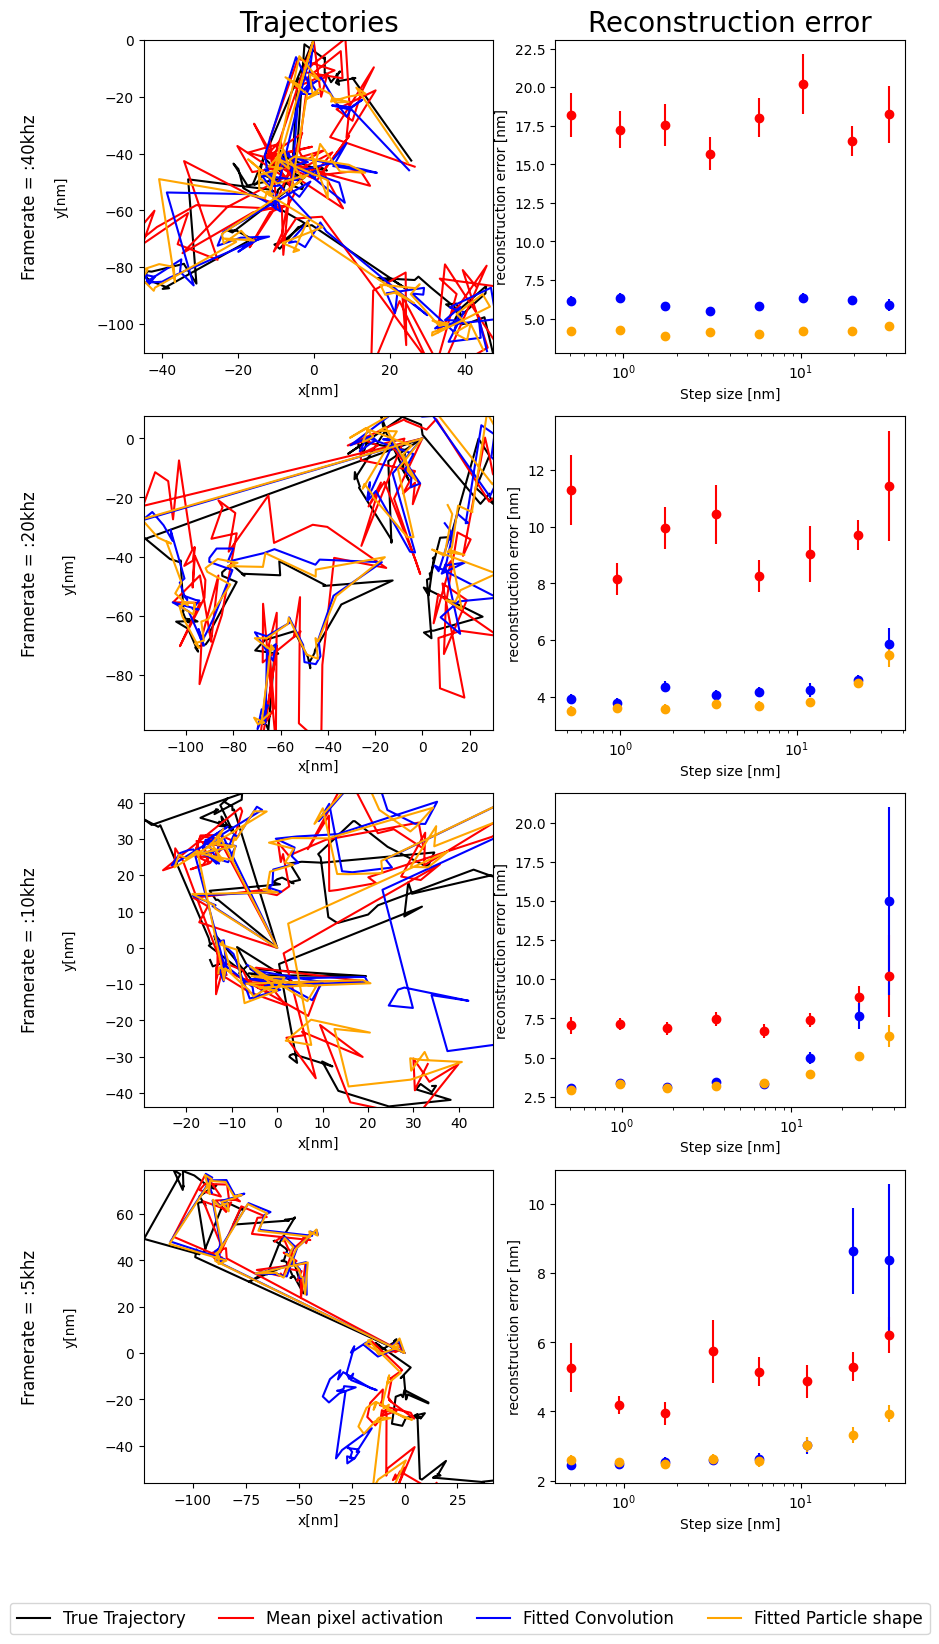

In [114]:
import matplotlib.pyplot as plt
import numpy as np
n_plotting_points = 100
n_plotted_errors = 8
nm_pro_pixel = (0.036768956332537246 * 1000)

def plot_comparison(tray_test, tray_ground_truth, ax,n_plotted= None, **kwargs):
    stepsize_bins, mean_squared_error, mean_squared_error_uncertainty = compare_trajectories(tray_test, tray_ground_truth)
    sorted_indices = sorted(range(len(stepsize_bins)), key=lambda k: stepsize_bins[k])
    Stepsize_bins = [stepsize_bins[i] for i in sorted_indices]
    stepsize_bin_error = [np.sqrt(mean_squared_error[i]) for i in sorted_indices]
    stepsize_bin_error_uncertainty = [0.5 * mean_squared_error_uncertainty[i] / np.sqrt(mean_squared_error[i]) for i in sorted_indices]
    if n_plotted is not None:
        ax.errorbar(Stepsize_bins[:n_plotted], stepsize_bin_error[:n_plotted], yerr=stepsize_bin_error_uncertainty[:n_plotted], fmt='o', **kwargs)
    else:
        ax.errorbar(Stepsize_bins, stepsize_bin_error, yerr=stepsize_bin_error_uncertainty, fmt='o', **kwargs)

fig, axs = plt.subplots(4, 2, figsize=(9, 16))  # 3 rows, 2 columns
plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust spacing between subplots

exposure_times_in_ms = [25, 50, 100, 200]
framerate_in_khz = [int(1000/exposure_time) for exposure_time in exposure_times_in_ms]

for i, (trajectory_PX, tra_mean_PX, tra_corr_PX, tra_gauss_PX) in enumerate(zip(trajectorie_list, tra_mean_list, tra_corr_list, tra_gauss_list)):

    ax_left = axs[i, 0]
    ax_right = axs[i, 1]

    if i == 0:
        ax_left.set_title('Trajectories', fontsize=20)
        ax_right.set_title('Reconstruction error', fontsize=20)


    # Plotting the trajectories
    #tra_corr_PX = extreme_stepsize_filter(tra_corr_PX.copy(), max_stepsize=10.)
    trajectory = trajectory_PX * nm_pro_pixel
    tra_mean = tra_mean_PX * nm_pro_pixel
    tra_corr = tra_corr_PX * nm_pro_pixel
    tra_gauss = tra_gauss_PX * nm_pro_pixel

    ax_left.plot(trajectory[:n_plotting_points, 1], trajectory[:n_plotting_points, 0], label='True Trajectory', color='black')
    ax_left.plot(tra_mean[:n_plotting_points, 1], tra_mean[:n_plotting_points, 0], label='Mean pixel activation', color='red')
    ax_left.plot(tra_corr[:n_plotting_points, 1], tra_corr[:n_plotting_points, 0], label='Fitted Convolution', color='blue')
    ax_left.plot(tra_gauss[:n_plotting_points, 1], tra_gauss[:n_plotting_points, 0], label='Fitted Particle shape', color='orange')

    x_min = trajectory[:n_plotting_points, 1].min() - 0.1
    x_max = trajectory[:n_plotting_points, 1].max() + 0.1
    y_min = trajectory[:n_plotting_points, 0].min() - 0.1
    y_max = trajectory[:n_plotting_points, 0].max() + 0.1
    ax_left.set_xlim(x_min, x_max)
    ax_left.set_ylim(y_min, y_max)
    ax_left.set_xlabel('x[nm]')
    ax_left.set_ylabel('y[nm]', labelpad=20)  # Increase labelpad to avoid overlap

    # Plotting the square distance from each trajectory to the true trajectory
    plot_comparison(tra_mean, trajectory, ax_right,n_plotted = n_plotted_errors, label='Mean pixel activation', color='red')
    plot_comparison(tra_corr, trajectory, ax_right,n_plotted = n_plotted_errors, label='Fitted Convolution', color='blue')
    plot_comparison(tra_gauss, trajectory, ax_right,n_plotted = n_plotted_errors, label='Fitted Particle shape', color='orange')
    
    ax_right.set_xlabel('Step size [nm]')
    ax_right.set_ylabel('reconstruction error [nm]')
    ax_right.set_xscale('log')
    #ax_right.set_yscale('log')
    #ax_right.set_xlim((0.3, 15))
    #ax_right.set_ylim((0,20))
    #ax_right.set_yscale('log')
    if i ==2:
        print("hallo")
        #ax_right.set_yticks([1.,2.,4.])
    # Add labels on the side for each row
    ax_left.annotate(f"Framerate = :{framerate_in_khz[i]}khz", xy=(-0.3, 0.5), xycoords='axes fraction', rotation=90, ha='right', va='center', fontsize=12)

# Add a single legend for all subplots
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:4], labels[:4], loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.03), fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 1])  # Adjust the bottom spacing to make room for the legend

plt.show()